In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

## Read Data

In [2]:
tweets = pd.read_csv("../data/tweets.csv", header=None)#.groupby(0).sample(frac=.01, random_state=1)
tweets.rename(columns={0:"sentiment", 1:"id", 2:"date", 4:"user", 5:"tweet"}, inplace=True)

# remap sentiments to 0 or 1 (negative or positive respectively)
tweets["sentiment"] = tweets["sentiment"].map({0:0, 4:1})
# remove unnecessary column
tweets.drop(3, axis=1, inplace=True)
# format date column
tweets["date"] = pd.to_datetime(tweets["date"])#.dt.date

/home/caio/Projects/tweet-sentiment-classification/.venv/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [3]:
pd.set_option("display.max_colwidth", 1000)
tweets.head()

,sentiment,id,date,user,tweet
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


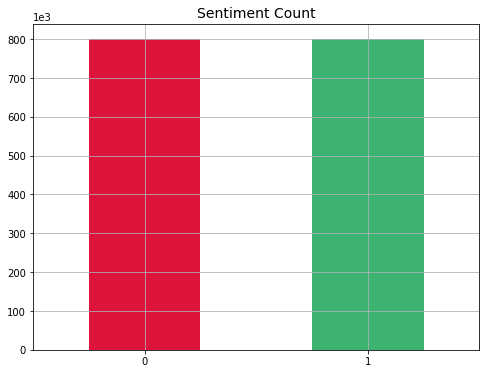

In [4]:
tweets["sentiment"].value_counts().plot.bar(rot=0, color=["crimson", "mediumseagreen"], grid=True, figsize=(8, 6))
plt.title("Sentiment Count", fontsize=14)
plt.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
plt.show()

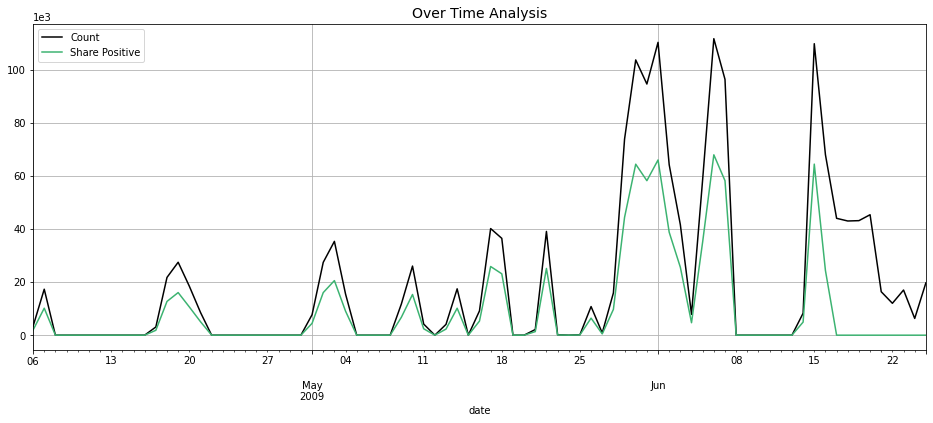

In [5]:
tweets.groupby("date").size().resample("D").sum().plot(color="k", grid=True, figsize=(16, 6))
tweets.groupby("date")["sentiment"].sum().resample("D").sum().plot(color="mediumseagreen", grid=True, figsize=(16, 6))
plt.title("Over Time Analysis", fontsize=14)
plt.legend(["Count", "Share Positive"])
plt.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
plt.show()

---
# Pre-Processing

In [6]:
# functions to clean tweets
def remove_usernames(tweet):
    return re.sub("@[a-zA-Z0-9]+\s+", "", tweet)

def remove_whitespaces(tweet):
    return re.sub("\s+", " ", tweet)

def remove_links(tweet):
    return re.sub("http\S+", "", tweet)

def remove_specific_patterns(tweet):
    return re.sub("[^a-zA-Z0-9\'\.!%#?\s]", "", tweet)

def cleaning_tweet(tweet):
    return remove_whitespaces(remove_specific_patterns(remove_links(remove_usernames(tweet))))

In [7]:
# apply cleaning
tweets["tweet"] = tweets["tweet"].apply(cleaning_tweet).str.lower()

In [8]:
tweets.head()

,sentiment,id,date,user,tweet
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,awww that's a bummer. you shoulda got david carr of third day to do it. d
1,0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his facebook by texting it... and might cry as a result school today also. blah!
2,0,1467810917,2009-04-06 22:19:53,mattycus,i dived many times for the ball. managed to save 50% the rest go out of bounds
3,0,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,Karoli,no it's not behaving at all. i'm mad. why am i here? because i can't see you all over there.


In [9]:
# train and test split
train = tweets.loc[tweets["date"] < "2009-06-01", ["date", "tweet", "sentiment"]]
test = tweets.loc[tweets["date"] >= "2009-06-01", ["date", "tweet", "sentiment"]]

print(f"Train Size: {train.shape[0]}")
print(f"Test Size: {test.shape[0]}")

Train Size: 676392
Test Size: 923608


In [10]:
print(f"Train Unique tokens: {len(set(' '.join(train['tweet'].tolist()).split()))}")
print(f"Train+Test Unique tokens: {len(set(' '.join(tweets['tweet'].tolist()).split()))}")

Train Unique tokens: 389833
Train+Test Unique tokens: 719994


In [11]:
# tweets metadata
lengths = train['tweet'].apply(lambda x: len(x.split()))

print(f"Longest tweet: {lengths.max()} words ({tweets['tweet'].apply(lambda x: len(x.split())).max()} Train+Test)")
print(f"Mean words per tweet: {lengths.mean():.2f}")
print(f"Median words per tweet: {lengths.median()}")

Longest tweet: 64 words (64 Train+Test)
Mean words per tweet: 12.49
Median words per tweet: 11.0


In [12]:
train.to_parquet("../data/train.parquet")
test.to_parquet("../data/test.parquet")